### This notebook plays around with node degrees and looks at the impact of systematically deleting SC ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import scipy.stats as stats

In [3]:
from collections import Counter

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [45]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [46]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [47]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 7.86 s, sys: 130 ms, total: 7.99 s
Wall time: 14.4 s


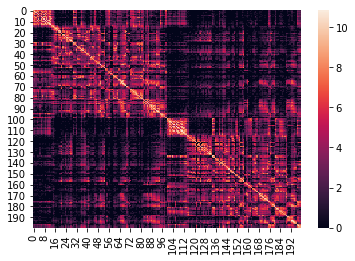

In [287]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

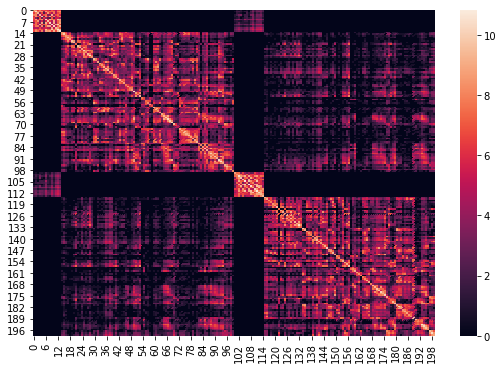

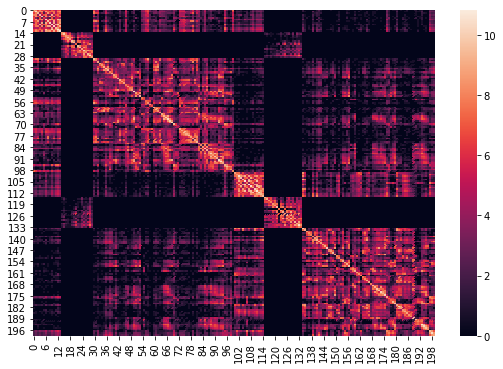

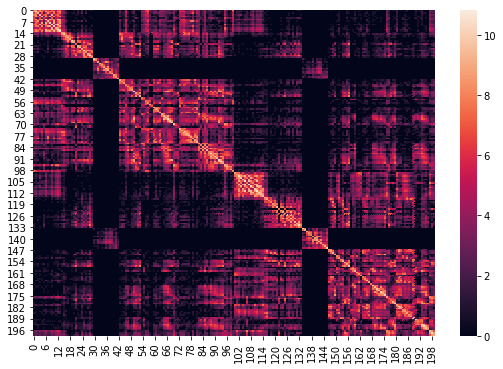

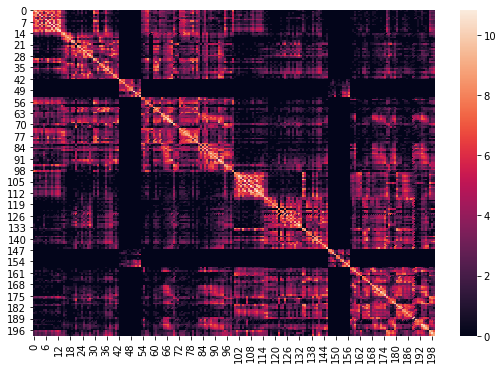

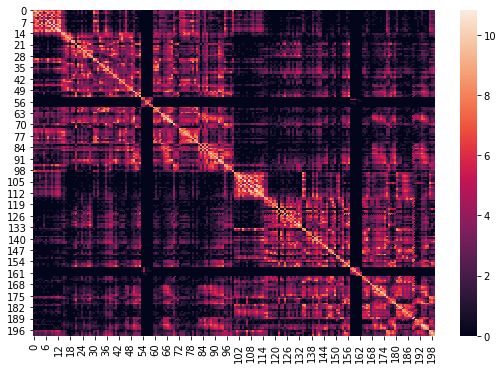

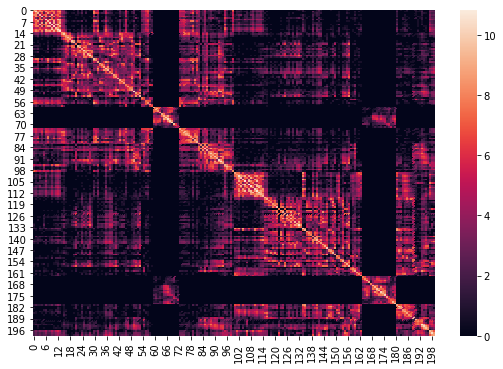

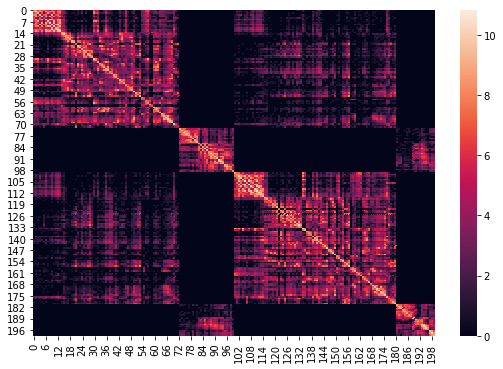

In [288]:
# a,b,c,d = 43,54,147,158

for i in range(7):
    a,b,c,d = ntwx_labels_idxs[i]
    modified_matrix = all_subs_pre_lap_SC[0].copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
    fig, ax = plt.subplots(figsize=(9,6))
    sns.heatmap(np.log1p(modified_matrix))

In [280]:
# modified_matrix = all_subs_pre_lap_SC[0].copy()

# modified_matrix[a:b,0:a] = 0
# modified_matrix[a:b,b:c] = 0
# modified_matrix[a:b,d:200] = 0
# modified_matrix[c:d,0:a] = 0
# modified_matrix[c:d,b:c] = 0
# modified_matrix[c:d,d:200] = 0

# modified_matrix[0:a,a:b] = 0
# modified_matrix[b:c,a:b] = 0
# modified_matrix[d:200,a:b] = 0
# modified_matrix[0:a,c:d] = 0
# modified_matrix[b:c,c:d] = 0
# modified_matrix[d:200,c:d] = 0

# modified_matrix = modified_matrix/np.linalg.norm(modified_matrix) # <-- what does this do ... ask Zheng

In [281]:
# sns.heatmap(modified_matrix,vmax=0.00001)

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 4s, sys: 655 ms, total: 1min 5s
Wall time: 1min 17s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.44 s, sys: 180 ms, total: 1.62 s
Wall time: 1.63 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [15]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 35s, sys: 2.56 s, total: 1min 38s
Wall time: 2min 38s


In [16]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

In [17]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is OUTER connectivity ... i.e., the average ntwx conn to other ntwx (so Vis to SomMot, DorsAttn, ..., DMN etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

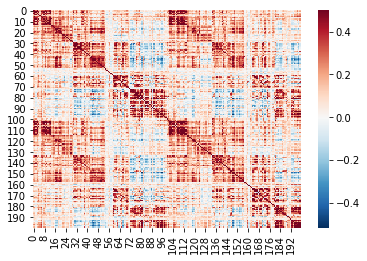

In [18]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

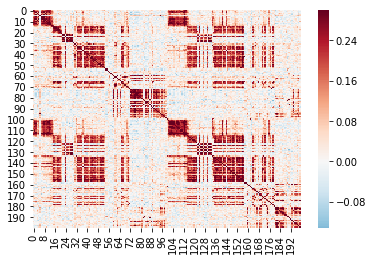

In [19]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [20]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [21]:
# corrs_list

In [22]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [25]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [26]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [27]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

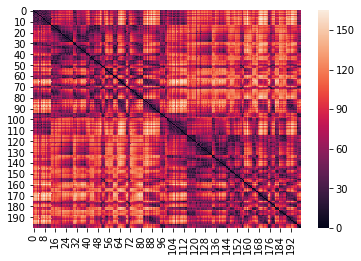

In [42]:
sns.heatmap(distance)

In [34]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [36]:
def ntwx_only_fc_modded_for_distance(dist_fc, a,b,c,d):
    
    ntwx_only_lh = dist_fc[a:b, a:b]
    ntwx_only_rh = dist_fc[c:d, c:d]

    ntwx_only_lhrh = dist_fc[a:b, c:d]
    ntwx_only_rhlh = dist_fc[c:d, a:b]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [35]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

## inner

### distance

In [38]:
%%time
# isolated ntwx mean distances

vis_dist = ntwx_only_fc_modded_for_distance(distance, 0, 14, 100, 115)
sommot_dist = ntwx_only_fc_modded_for_distance(distance, 14, 30, 115, 134)
dorsattn_dist = ntwx_only_fc_modded_for_distance(distance, 30, 43, 134, 147)
ventattn_dist = ntwx_only_fc_modded_for_distance(distance, 43, 54, 147, 158)
limbic_dist = ntwx_only_fc_modded_for_distance(distance, 54, 60, 158, 164)
fpn_dist = ntwx_only_fc_modded_for_distance(distance, 60, 73, 164, 181)
dmn_dist = ntwx_only_fc_modded_for_distance(distance, 73, 100, 181, 200)

CPU times: user 800 µs, sys: 1.02 ms, total: 1.82 ms
Wall time: 1.57 ms


In [41]:
print(vis_dist)
print(sommot_dist)
print(dorsattn_dist)
print(ventattn_dist)
print(limbic_dist)
print(fpn_dist)
print(dmn_dist)

45.35938971494109
60.40041387385497
66.2928255275078
68.01066541396722
48.927782492713234
78.53465065504756
79.49668489578892


In [203]:
mean_dists = [45.35938971494109,60.40041387385497,66.2928255275078,68.01066541396722,48.927782492713234,78.53465065504756,79.49668489578892]


### streamlines

In [60]:
%%time
# str fc streamlines for isolated ntwx

all_subs_mean_vis_streamlines = []
all_subs_mean_smt_streamlines = []
all_subs_mean_dan_streamlines = []
all_subs_mean_van_streamlines = []
all_subs_mean_lim_streamlines = []
all_subs_mean_fpn_streamlines = []
all_subs_mean_dmn_streamlines = []

for i in range(200):
    vis_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 0, 14, 100, 115)
    sommot_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 14, 30, 115, 134)
    dorsattn_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 30, 43, 134, 147)
    ventattn_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 43, 54, 147, 158)
    limbic_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 54, 60, 158, 164)
    fpn_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 60, 73, 164, 181)
    dmn_ss_mean_strams = ntwx_only_fc(all_subs_pre_lap_SC, i, 73, 100, 181, 200)
    
    all_subs_mean_vis_streamlines.append(vis_ss_mean_strams)
    all_subs_mean_smt_streamlines.append(sommot_ss_mean_strams)
    all_subs_mean_dan_streamlines.append(dorsattn_ss_mean_strams)
    all_subs_mean_van_streamlines.append(ventattn_ss_mean_strams)
    all_subs_mean_lim_streamlines.append(limbic_ss_mean_strams)
    all_subs_mean_fpn_streamlines.append(fpn_ss_mean_strams)
    all_subs_mean_dmn_streamlines.append(dmn_ss_mean_strams)

CPU times: user 193 ms, sys: 27.5 ms, total: 220 ms
Wall time: 204 ms


In [76]:
x_labels = range(len(all_subs_mean_vis_streamlines))

In [80]:
all_subs_all_ntwx_streams = [all_subs_mean_vis_streamlines,all_subs_mean_smt_streamlines,
                             all_subs_mean_dan_streamlines,all_subs_mean_van_streamlines,
                             all_subs_mean_lim_streamlines,all_subs_mean_fpn_streamlines,
                             all_subs_mean_dmn_streamlines]

In [114]:
# for i in range(7):
#     fig, ax = plt.subplots(figsize=(15,5))
#     plt.bar(x_labels, all_subs_all_ntwx_streams[i])

In [82]:
for i in range(7):
    print(np.mean(all_subs_all_ntwx_streams[i]))

1614.6410747732425
472.16540028241866
472.8020266272189
453.8872520661157
461.2352777777778
456.2985811101329
443.0680653306431


In [202]:
mean_streams = [1614.6410747732425,472.16540028241866,472.8020266272189,453.8872520661157,461.2352777777778,456.2985811101329,443.0680653306431]

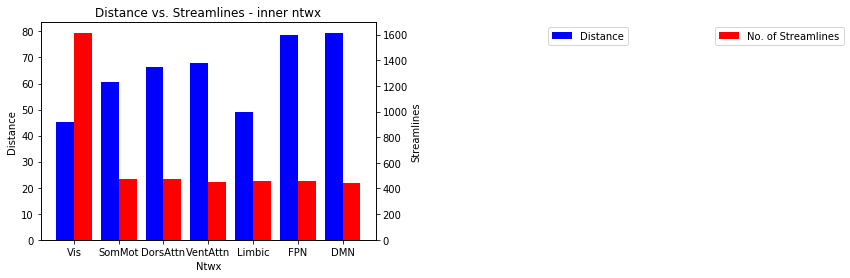

In [205]:
categories = Ntwx_labels.copy()
values = mean_dists
new_values2 = mean_streams

# Set the bar width
bar_width = 0.4

# Calculate the center positions for each bar group
x_positions = np.arange(len(categories))

# Create the primary y-axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot 'values' on the primary y-axis
ax1.bar(x_positions, values, width=bar_width, color='b', label='Distance')

# Plot 'new_values2' on the secondary y-axis
ax2.bar(x_positions + bar_width, new_values2, width=bar_width, color='r', label='No. of Streamlines')

# Set the x-axis ticks and labels
ax1.set_xticks(x_positions + bar_width / 2)
ax1.set_xticklabels(categories)

# Set the labels and title for the two y-axes
ax1.set_xlabel('Ntwx')
ax1.set_ylabel('Distance')
ax2.set_ylabel('Streamlines')
plt.title('Distance vs. Streamlines - inner ntwx')

# Display legends for both sets of data
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Move the legend to the right outside the plot
ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(2, 1))

# Show the plot
plt.tight_layout()

# Show the plot
plt.show()

### fc 

### original whobpyt

In [85]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs)
org_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs)
org_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs)
org_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(org_whobpyt_limbic_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 130 ms, sys: 17.7 ms, total: 147 ms
Wall time: 142 ms


### lesion 

In [87]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [88]:
org2_whobpyt_means, org2_all_subs = func_for_inner_ntwx_connectivity(all_subs_og_whobpyt)

In [89]:
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means, sommot_all_subs = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means, dorsattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means, ventattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means, limbic_all_subs = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

# ---------------------------------------------------------------------------------------------------------------

## Outer

In [101]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc

In [102]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [103]:
def outer_ntwx_only_fc_modded_for_distance(fc, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc

In [104]:
%%time

all_subs_dist_vis_to_other_ntwx = []
all_subs_dist_sommot_to_other_ntwx = []
all_subs_dist_dorsattn_to_other_ntwx = []
all_subs_dist_ventattn_to_other_ntwx = []
all_subs_dist_limbic_to_other_ntwx = []
all_subs_dist_fpn_to_other_ntwx = []
all_subs_dist_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,0)
    all_subs_dist_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,1)
    all_subs_dist_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,2)
    all_subs_dist_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,3)
    all_subs_dist_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,4)
    all_subs_dist_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,5)
    all_subs_dist_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_modded_for_distance(distance,6)
    all_subs_dist_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 785 ms, sys: 8.74 ms, total: 794 ms
Wall time: 774 ms


In [105]:
dist_from_vis_to_other_ntwx = np.mean(all_subs_dist_vis_to_other_ntwx,axis=0)
dist_from_sommot_to_other_ntwx = np.mean(all_subs_dist_sommot_to_other_ntwx,axis=0)
dist_from_dorsattn_to_other_ntwx = np.mean(all_subs_dist_dorsattn_to_other_ntwx,axis=0)
dist_from_ventattn_to_other_ntwx = np.mean(all_subs_dist_ventattn_to_other_ntwx,axis=0)
dist_from_limbic_to_other_ntwx = np.mean(all_subs_dist_limbic_to_other_ntwx,axis=0)
dist_from_fpn_to_other_ntwx = np.mean(all_subs_dist_fpn_to_other_ntwx,axis=0)
dist_from_dmn_to_other_ntwx = np.mean(all_subs_dist_dmn_to_other_ntwx,axis=0)

In [106]:
# Across all 200 subs
dist_from_outer_to_other_ntwx  = [dist_from_vis_to_other_ntwx,dist_from_sommot_to_other_ntwx,
                                  dist_from_dorsattn_to_other_ntwx,dist_from_ventattn_to_other_ntwx,
                                  dist_from_limbic_to_other_ntwx,dist_from_fpn_to_other_ntwx,
                                  dist_from_dmn_to_other_ntwx]

In [120]:
# for i in range(7):
#     print(dist_from_outer_to_other_ntwx[i])

In [115]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

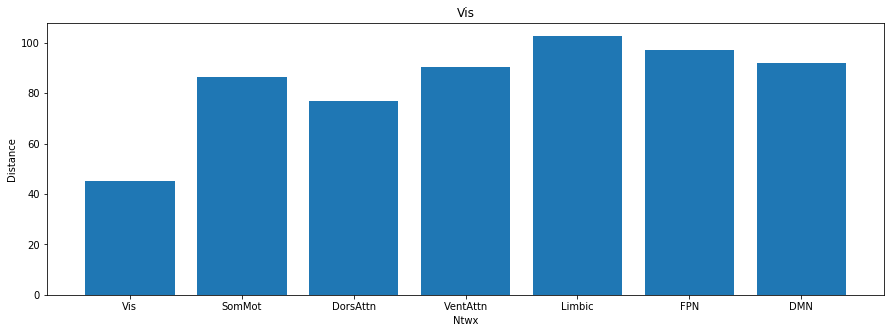

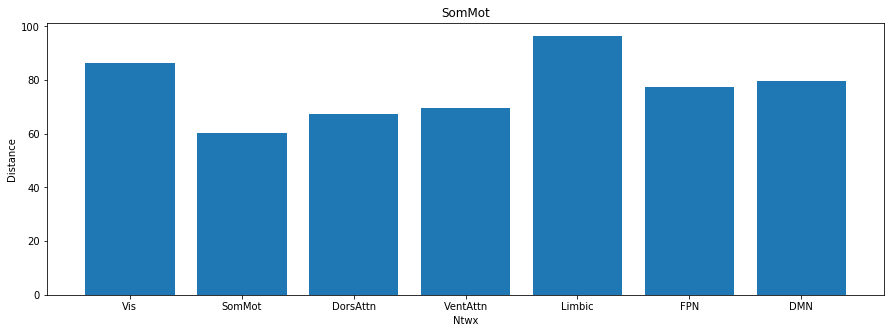

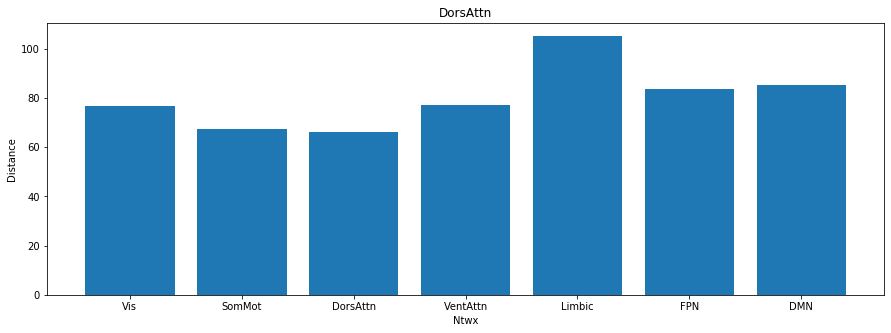

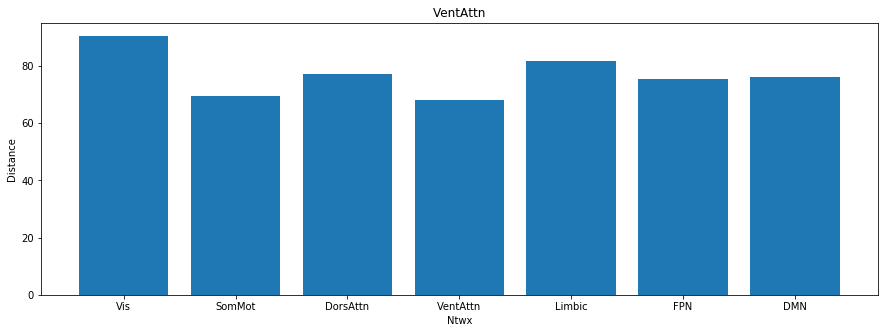

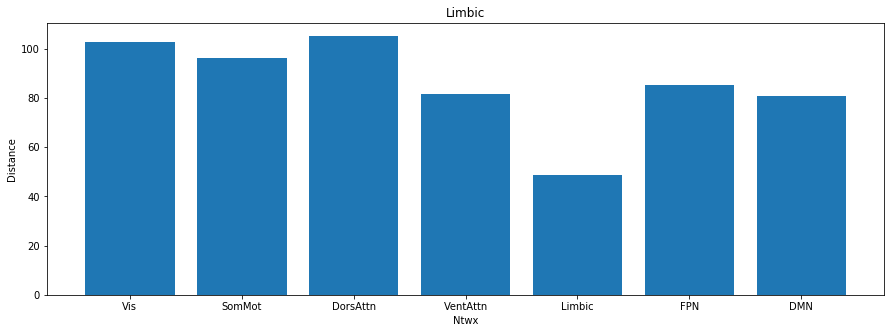

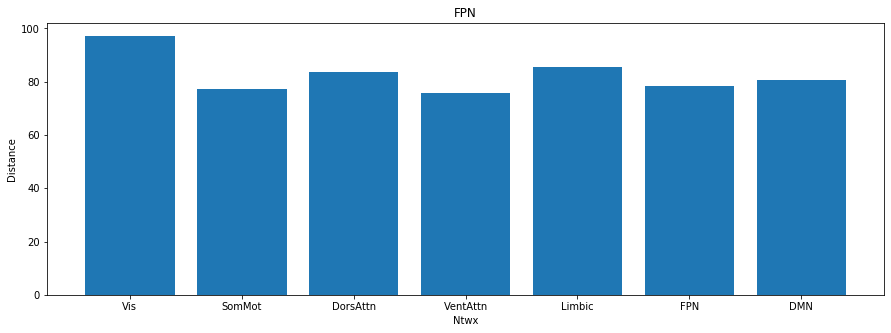

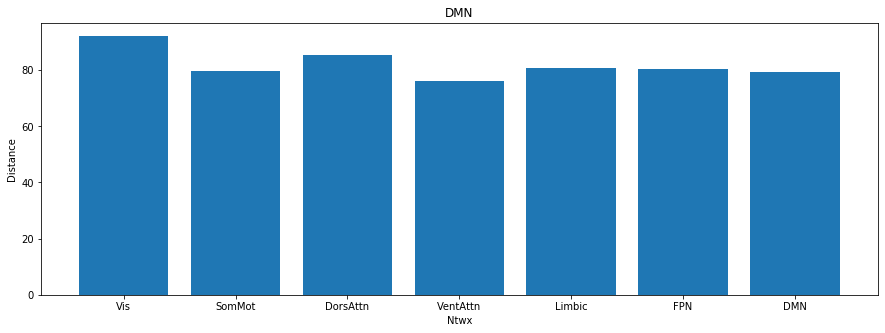

In [189]:
for i in range(7):
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(Ntwx_labels, dist_from_outer_to_other_ntwx[i])
    plt.xlabel('Ntwx')
    plt.ylabel('Distance')
    plt.title(Ntwx_labels[i])

### Number of streamlines

In [126]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

streamlines_lesion_vis_to_other_ntwx, streamlines_lesion_sommot_to_other_ntwx, streamlines_lesion_dorsattn_to_other_ntwx, streamlines_lesion_ventattn_to_other_ntwx, streamlines_lesion_limbic_to_other_ntwx, streamlines_lesion_fpn_to_other_ntwx, streamlines_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_pre_lap_SC)



CPU times: user 958 ms, sys: 6.41 ms, total: 964 ms
Wall time: 951 ms


In [128]:

print(streamlines_lesion_vis_to_other_ntwx)
print(streamlines_lesion_sommot_to_other_ntwx)
print(streamlines_lesion_dorsattn_to_other_ntwx)
print(streamlines_lesion_ventattn_to_other_ntwx)
print(streamlines_lesion_limbic_to_other_ntwx)
print(streamlines_lesion_fpn_to_other_ntwx)
print(streamlines_lesion_dmn_to_other_ntwx)



[1614.64107477    6.56167887   87.20351603   12.65056602   64.84504663
   24.5578935    50.18350275]
[  6.56167887 472.16540028  97.99196483 127.60659091   6.60427632
  33.9726171   24.86786297]
[ 87.20351603  97.99196483 472.80202663  85.46817308  35.85887821
 113.11144057  72.40042735]
[ 12.65056602 127.60659091  85.46817308 453.88725207  20.67034091
  91.37953414  99.64118089]
[ 64.84504663   6.60427632  35.85887821  20.67034091 461.23527778
  56.53905637  81.64322531]
[ 24.5578935   33.9726171  113.11144057  91.37953414  56.53905637
 456.29858111 141.55740547]
[ 50.18350275  24.86786297  72.40042735  99.64118089  81.64322531
 141.55740547 443.06806533]


In [220]:
all_streamlines = [streamlines_lesion_vis_to_other_ntwx,streamlines_lesion_sommot_to_other_ntwx,
streamlines_lesion_dorsattn_to_other_ntwx,streamlines_lesion_ventattn_to_other_ntwx,
streamlines_lesion_limbic_to_other_ntwx,streamlines_lesion_fpn_to_other_ntwx,
streamlines_lesion_dmn_to_other_ntwx]

In [129]:
# 0 - vis
# 1 - smt
# 2 - dan
# 3 - van
# 4 - lim
# 5 - fpn
# 6 - dmn

In [216]:
temp_label_list = Ntwx_labels.copy()

In [221]:
for i in range(7):
    all_streamlines[i] = all_streamlines[i].tolist()

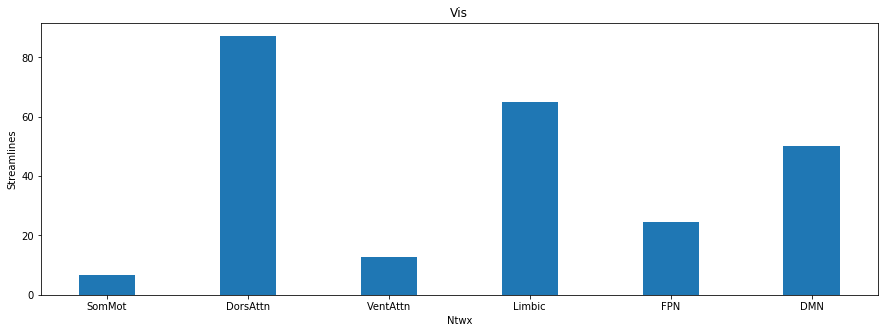

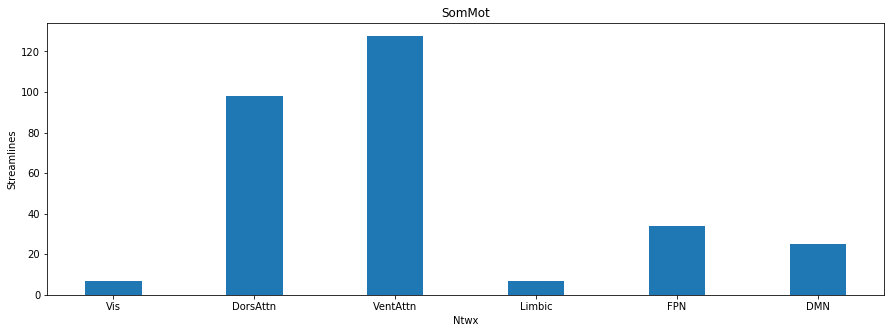

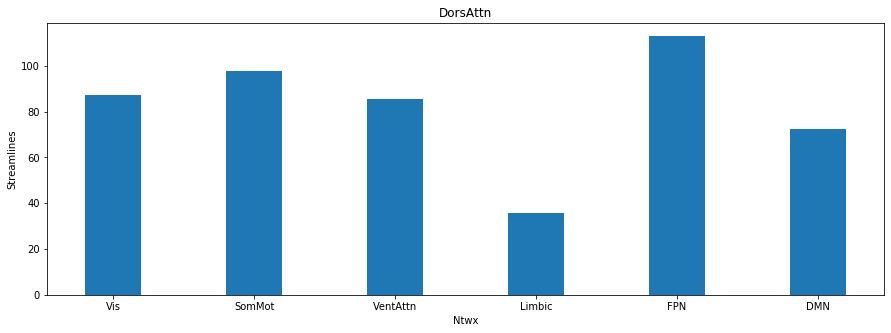

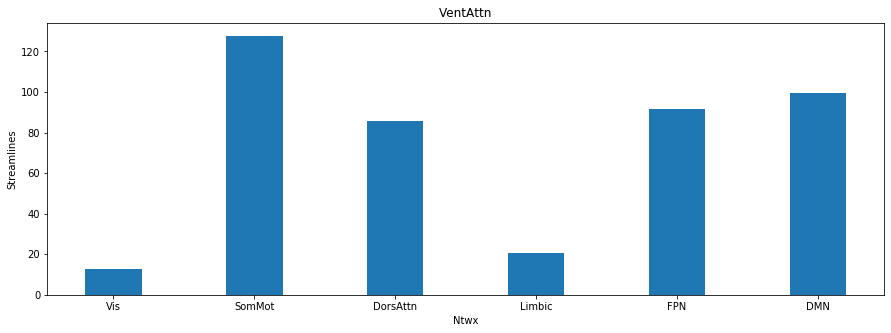

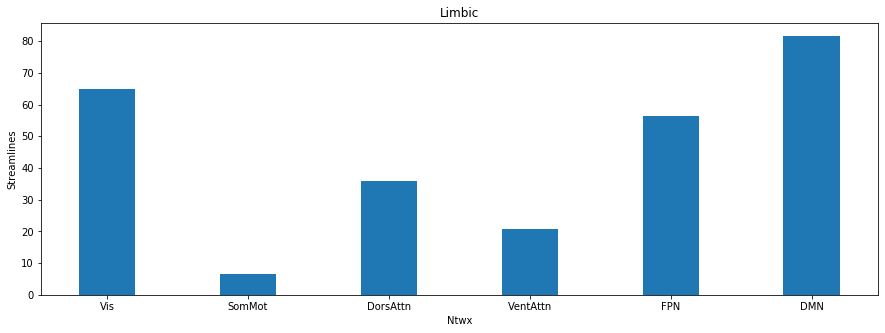

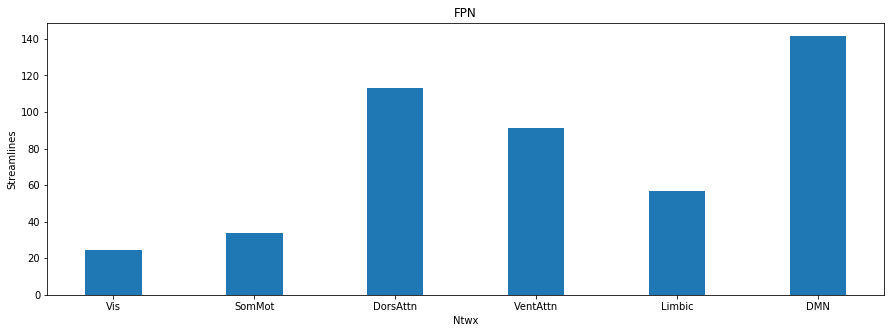

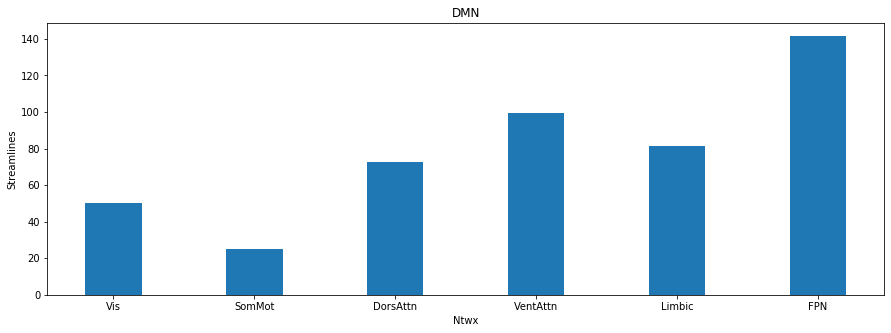

In [224]:
for i in range(7):
    streams = all_streamlines[i]
    dists = dist_from_outer_to_other_ntwx[i]
    temp_label_list = Ntwx_labels.copy()
    temp_list = []
    temp_dist_list = []
    max_val = max(streams)
    max_index = streams.index(max_val)
    temp_label_list.pop(max_index)
    temp_list.extend(streams[:max_index] + streams[max_index + 1:])
    temp_dist_list.extend(dists[:max_index] + dists[max_index + 1:])
#     print(temp_label_list)
#     print(temp_list)
#     print(temp_dist_list)
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(temp_label_list, temp_list,width = 0.4,align='center')
    plt.xlabel('Ntwx')
    plt.ylabel('Streamlines')
    plt.title(Ntwx_labels[i])

In [227]:
for i in range(7):
    dist_from_outer_to_other_ntwx[i] = dist_from_outer_to_other_ntwx[i].tolist()

In [229]:
# dist_from_outer_to_other_ntwx

In [225]:
# for i in range(7):
#     streams = all_streamlines[i]
#     fig, ax = plt.subplots(figsize=(15,5))
#     plt.bar(Ntwx_labels, streams,width = 0.4,align='center')
#     plt.xlabel('Ntwx')
#     plt.ylabel('Streamlines')
#     plt.title(Ntwx_labels[i])

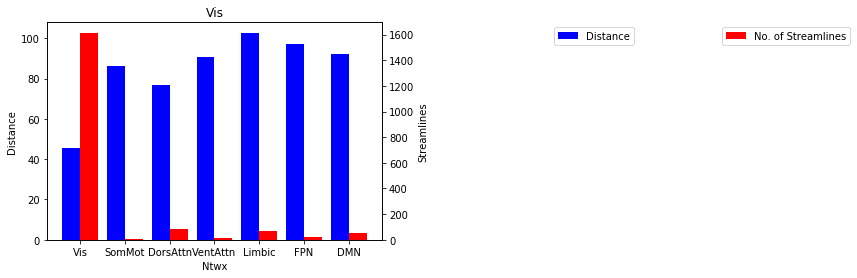

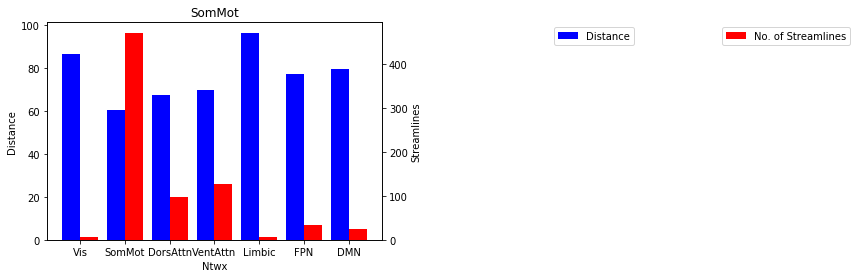

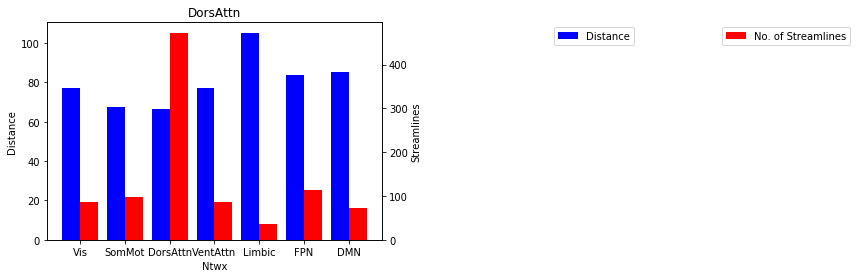

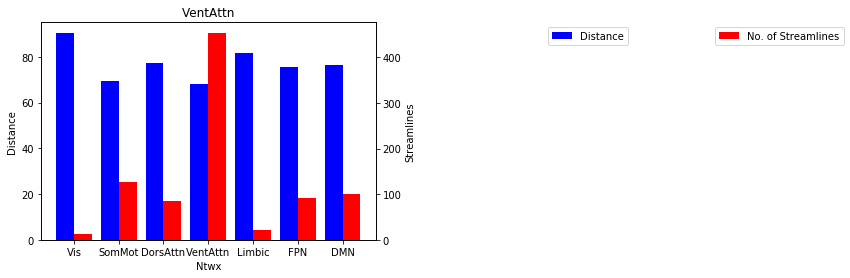

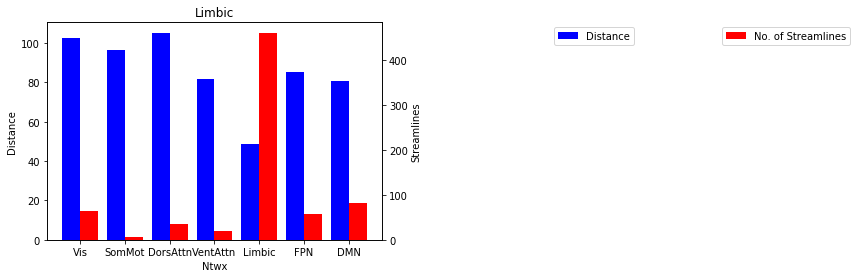

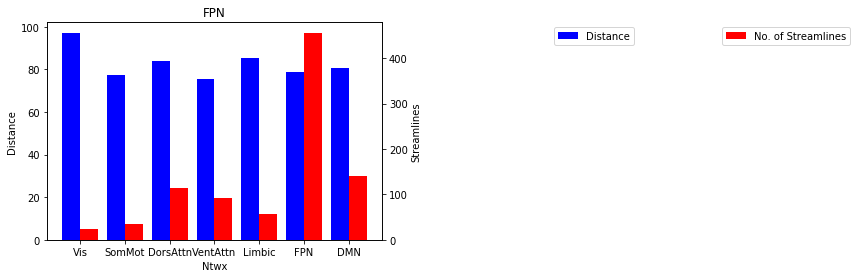

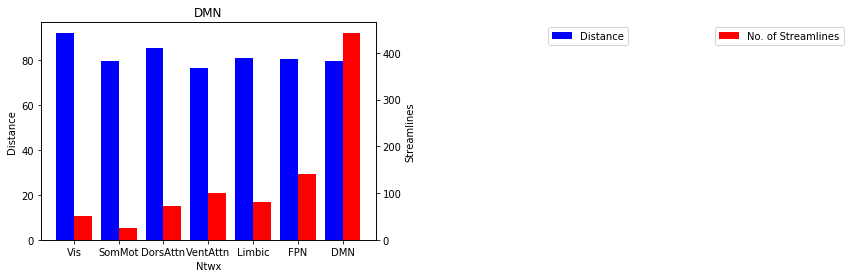

In [201]:
for i in range(7):
    

    categories = Ntwx_labels.copy()
    values = dist_from_outer_to_other_ntwx[i]
    new_values2 = all_streamlines[i]

    # Set the bar width
    bar_width = 0.4

    # Calculate the center positions for each bar group
    x_positions = np.arange(len(categories))

    # Create the primary y-axis
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Plot 'values' on the primary y-axis
    ax1.bar(x_positions, values, width=bar_width, color='b', label='Distance')

    # Plot 'new_values2' on the secondary y-axis
    ax2.bar(x_positions + bar_width, new_values2, width=bar_width, color='r', label='No. of Streamlines')

    # Set the x-axis ticks and labels
    ax1.set_xticks(x_positions + bar_width / 2)
    ax1.set_xticklabels(categories)

    # Set the labels and title for the two y-axes
    ax1.set_xlabel('Ntwx')
    ax1.set_ylabel('Distance')
    ax2.set_ylabel('Streamlines')
    plt.title(Ntwx_labels[i])

    # Display legends for both sets of data
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # Move the legend to the right outside the plot
    ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(2, 1))

    # Show the plot
    plt.tight_layout()

    # Show the plot
    plt.show()


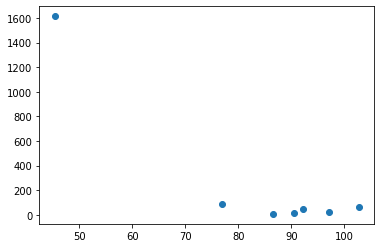

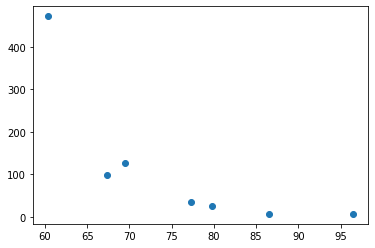

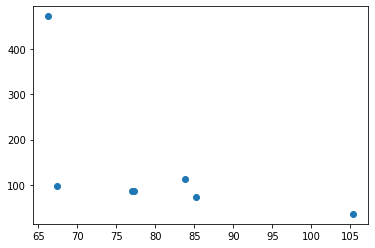

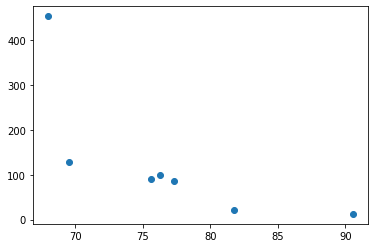

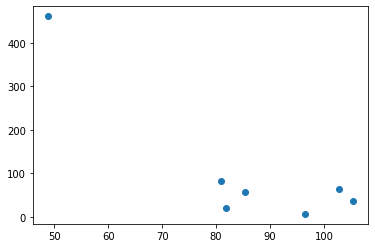

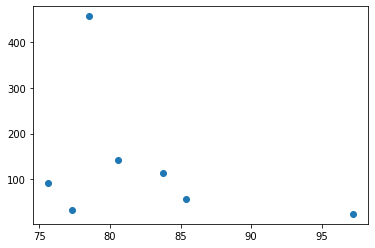

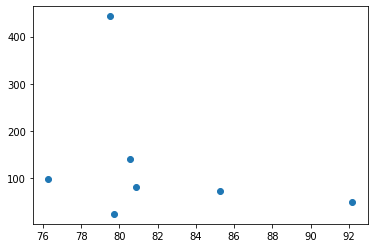

In [207]:
for i in range(7):
    

    categories = Ntwx_labels.copy()
    values = dist_from_outer_to_other_ntwx[i]
    new_values2 = all_streamlines[i]
    fig, ax1 = plt.subplots()
    plt.scatter(values,new_values2)

In [209]:
for i in range(7):
    

    categories = Ntwx_labels.copy()
    values = dist_from_outer_to_other_ntwx[i]
    new_values2 = all_streamlines[i]
    print(np.corrcoef(values,new_values2)[0][1])

-0.9080583563567289
-0.759260900410674
-0.5746912964015554
-0.7243735061788292
-0.8612606773681415
-0.3571045148128647
-0.300512465248574


In [243]:
%%time

outter_other_streams = []
outter_other_dists = []
alt_labels = []

for i in range(7):
    streams = all_streamlines[i]
    dists = dist_from_outer_to_other_ntwx[i]
    temp_label_list = Ntwx_labels.copy()
    temp_list = []
    temp_dist_list = []
    max_val = max(streams)
    max_index = streams.index(max_val)
    temp_label_list.pop(max_index)
    temp_list.extend(streams[:max_index] + streams[max_index + 1:])
    temp_dist_list.extend(dists[:max_index] + dists[max_index + 1:])
#     print(temp_label_list)
#     print(temp_list)
#     print(temp_dist_list)
    outter_other_streams.append(temp_list)
    outter_other_dists.append(temp_dist_list)
    alt_labels.append(temp_label_list)

CPU times: user 66 µs, sys: 0 ns, total: 66 µs
Wall time: 72 µs


In [249]:
for i in range(7):
    print(alt_labels[i])
    print(outter_other_streams[i])

['SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[6.561678865131578, 87.20351602564104, 12.65056601731602, 64.8450466269841, 24.557893503555274, 50.18350274993041]
['Vis', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[6.561678865131578, 97.99196482793528, 127.60659090909094, 6.60427631578947, 33.97261710377469, 24.867862972260706]
['Vis', 'SomMot', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[87.20351602564104, 97.99196482793528, 85.46817307692304, 35.858878205128214, 113.11144056735122, 72.40042735042734]
['Vis', 'SomMot', 'DorsAttn', 'Limbic', 'FPN', 'DMN']
[12.65056601731602, 127.60659090909094, 85.46817307692304, 20.670340909090914, 91.37953414232827, 99.64118088782561]
['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'FPN', 'DMN']
[64.8450466269841, 6.60427631578947, 35.858878205128214, 20.670340909090914, 56.53905637254902, 81.64322530864197]
['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'DMN']
[24.557893503555274, 33.97261710377469, 113.11144056735122, 91.37953414232827, 56.

In [ ]:
outter_other_dists

In [250]:
for i in range(7):
    print(alt_labels[i])
    print(outter_other_dists[i])

['SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[86.49642790028888, 76.96779846024174, 90.53080994787892, 102.76934895838939, 97.17764206873588, 92.1853310673593]
['Vis', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[86.49642790028888, 67.36592391714787, 69.52410021761574, 96.42927943756482, 77.32190936837506, 79.74210000821952]
['Vis', 'SomMot', 'VentAttn', 'Limbic', 'FPN', 'DMN']
[76.96779846024174, 67.36592391714788, 77.31343412823833, 105.29715071142569, 83.77459834665932, 85.24441522242837]
['Vis', 'SomMot', 'DorsAttn', 'Limbic', 'FPN', 'DMN']
[90.53080994787892, 69.52410021761574, 77.31343412823833, 81.77377980680788, 75.6406281443156, 76.29598986996862]
['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'FPN', 'DMN']
[102.76934895838939, 96.42927943756482, 105.29715071142569, 81.77377980680788, 85.34870547493446, 80.86117839358664]
['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'DMN']
[97.17764206873588, 77.32190936837506, 83.77459834665932, 75.6406281443156, 85.348705

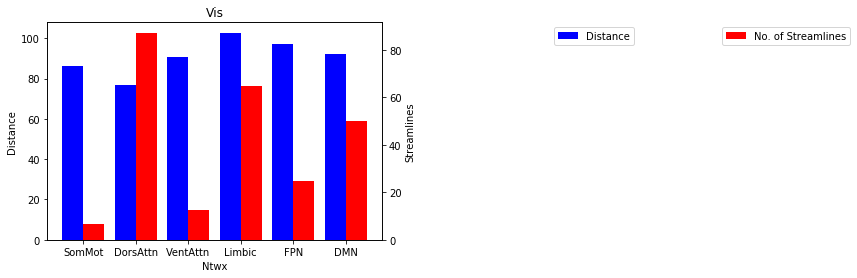

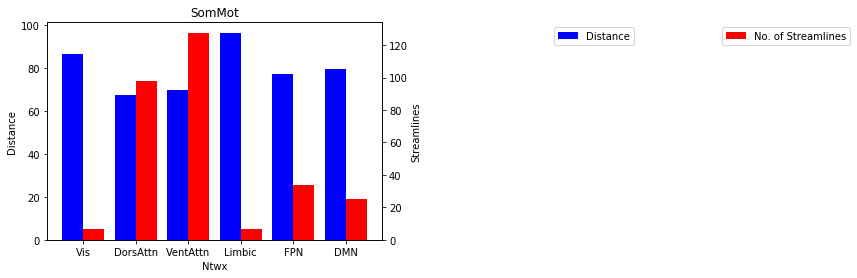

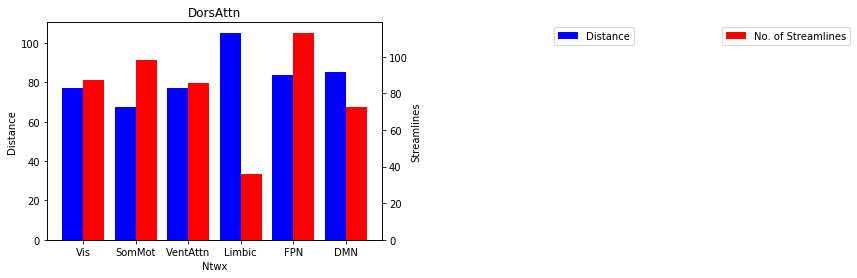

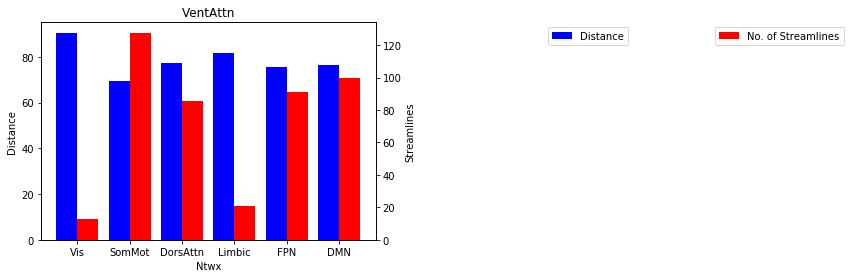

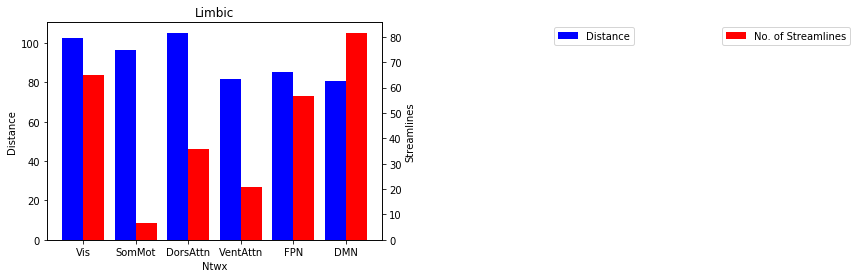

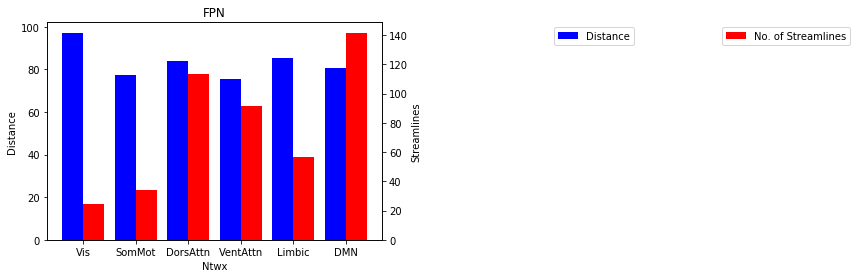

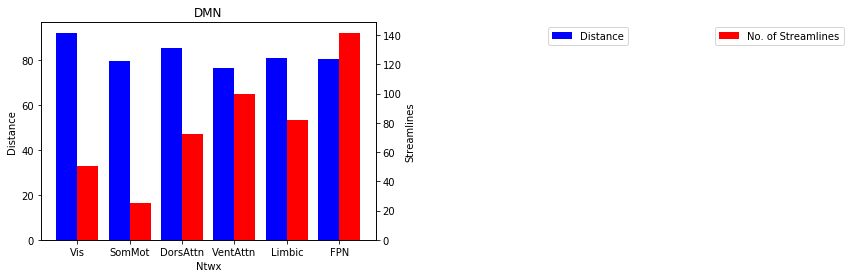

In [245]:
for i in range(7):
    

    categories = alt_labels[i]
    values = outter_other_dists[i]
    new_values2 = outter_other_streams[i]

    # Set the bar width
    bar_width = 0.4

    # Calculate the center positions for each bar group
    x_positions = np.arange(len(categories))

    # Create the primary y-axis
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Plot 'values' on the primary y-axis
    ax1.bar(x_positions, values, width=bar_width, color='b', label='Distance')

    # Plot 'new_values2' on the secondary y-axis
    ax2.bar(x_positions + bar_width, new_values2, width=bar_width, color='r', label='No. of Streamlines')

    # Set the x-axis ticks and labels
    ax1.set_xticks(x_positions + bar_width / 2)
    ax1.set_xticklabels(categories)

    # Set the labels and title for the two y-axes
    ax1.set_xlabel('Ntwx')
    ax1.set_ylabel('Distance')
    ax2.set_ylabel('Streamlines')
    plt.title(Ntwx_labels[i])

    # Display legends for both sets of data
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # Move the legend to the right outside the plot
    ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(2, 1))

    # Show the plot
    plt.tight_layout()

    # Show the plot
    plt.show()


In [239]:
for i in range(7):
    dists2 = outter_other_dists[i]
    streams2 = outter_other_streams[i]
    print(np.corrcoef(dists2,streams2)[0][1])

-0.20524150029955984
-0.8570752760580529
-0.7876144176284805
-0.9304390810048722
-0.20459453351447474
-0.43690568401212826
-0.3578353957604216


In [241]:
np.mean([-0.20524150029955984,
-0.8570752760580529,
-0.7876144176284805,
-0.9304390810048722,
-0.20459453351447474,
-0.43690568401212826,
-0.3578353957604216])

-0.5399579840397128

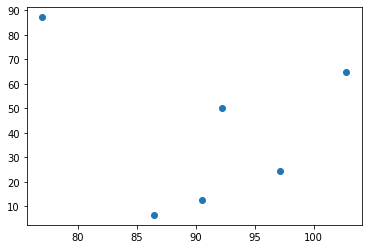

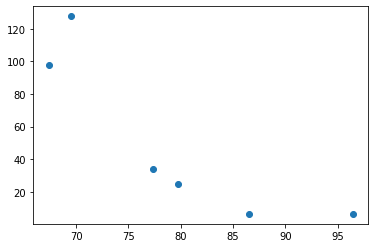

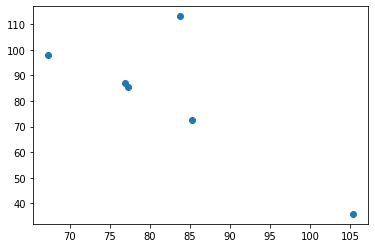

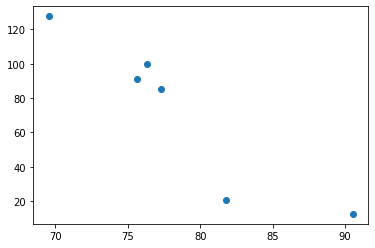

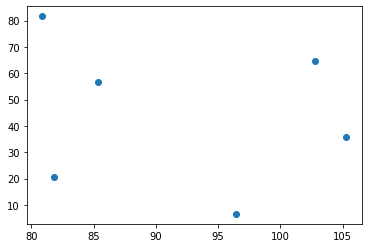

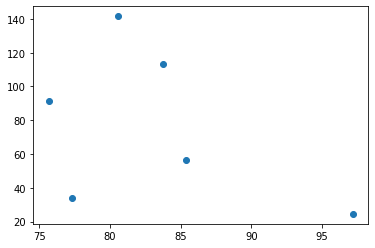

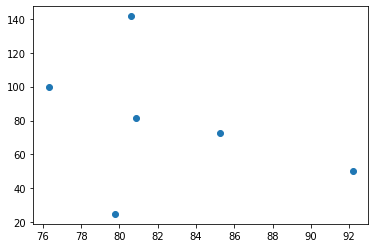

In [240]:
for i in range(7):
    values = outter_other_dists[i]
    new_values2 = outter_other_streams[i]
    fig, ax1 = plt.subplots()
    plt.scatter(values,new_values2)

## fc

### original whobpyt

In [91]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 846 ms, sys: 44.3 ms, total: 890 ms
Wall time: 879 ms


In [92]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [93]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

### lesion whobpyt

In [94]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [95]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.53 s, sys: 149 ms, total: 5.68 s
Wall time: 5.66 s


In [96]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [97]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]
vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [98]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [ ]:
# Next step: re-introduce sc for each of the other networks 